In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

from astropy import units as u
from astropy.coordinates import SkyCoord

sys.path.append(os.path.expanduser("~")+'/git/Python/user_modules/')
from match_coord import search_around, scatter_plot, match_coord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def relative_density_plot(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, vmin=-3, vmax=3, unit='arcsec'):
    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    mask = (d2d>2.)
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    density_ratio = density/ref_density
    if unit=='arcsec':
        extent = bins.max()*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = bins.max()*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = bins.max()*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(density_ratio.transpose()-1, origin='lower', aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    return ax, bins, mesh_d2d, density_ratio

def relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, vmin=-3, vmax=3, unit='arcsec'):
    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    mask = (d2d>2.)
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    density_ratio = density/ref_density
    if unit=='arcsec':
        extent = bins.max()*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = bins.max()*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = bins.max()*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    
    fig, ax = plt.subplots(1, 2, figsize=(17, 6.5))
    dens = ax[0].imshow(density_ratio.transpose()-1, origin='lower', aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    fig.colorbar(dens, ax=ax[0], fraction=0.046, pad=0.04)
    ax[0].axis(axis)
    ax[0].set_xlabel('$\Delta$RA (arcsec)')
    ax[0].set_ylabel('$\Delta$DEC (arcsec)')
    # plt.show()

    ax[1].plot(mesh_d2d.flatten(), density_ratio.flatten()-1, '.', markersize=1.5)
    # plt.axvline(mask_length1/2, lw=1, color='k')
    # plt.axvline(mask_length2/2, lw=1, color='k')
    ax[1].set_xlabel('distance (arcsec)')
    ax[1].set_ylabel('fractional overdensity')
    ax[1].grid(alpha=0.5)
    ax[1].axis([0, search_radius, -1, 6])
    
    return ax, bins, mesh_d2d, density_ratio

__0.37.0 target class maskbits: LRG: 0, LRG: 1, QSO: 2__   
https://github.com/desihub/desitarget/blob/0.37.0/py/desitarget/data/targetmask.yaml

In [4]:
target_bits = {'LRG':0, 'ELG':1, 'QSO':2}

In [5]:
# target_path_dr9sv = '/global/cfs/cdirs/desi/target/catalogs/dr9sv/0.37.0/targets/main/resolve/dark/targets-dr9-hp-X.fits'
# random_path_dr9sv = '/global/project/projectdirs/cosmo/data/legacysurvey/dr9sv/randoms/randoms-dr9-hp-X-1.fits'
gaia_columns = ['RA', 'DEC', 'PHOT_G_MEAN_MAG']
target_columns = ['BRICKID', 'MORPHTYPE', 'RA', 'DEC', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_W1', 'FLUX_W2', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'WISEMASK_W1', 'WISEMASK_W2', 'MASKBITS', 'PHOTSYS', 'DESI_TARGET']

---------------
## South

In [6]:
target_path = '/global/cscratch1/sd/rongpu/dr9dev/dr8_targets_in_dr9sv_region/dr8_south.fits'
gaia_path = '/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_south.fits'
region = b'S'
target_class = 'LRG'
target_bit = target_bits[target_class]

In [7]:
gaia = fitsio.read(gaia_path, columns=gaia_columns)
print(len(gaia))

cat = fitsio.read(target_path, columns=['DESI_TARGET', 'PHOTSYS'])
print(len(cat))
mask = ((cat["DESI_TARGET"] & (2**target_bit))!=0) & (cat['PHOTSYS']==region)
idx = np.where(mask)[0]
cat = fitsio.read(target_path, columns=target_columns, rows=idx)
cat = Table(cat)
print(len(cat))

7409227
3085614
240433


In [8]:
# Apply mask bits
mask = np.ones(len(cat), dtype=bool)
for bit in [1, 5, 6, 7, 11, 12, 13]:
        mask &= ((cat['MASKBITS'] & 2**bit) == 0)
print('{:} ({:.1f}%) objects removed due to maskbits'.format(np.sum(~mask), np.sum(~mask)/len(mask)*100))
cat = cat[mask]

9208 (3.8%) objects removed due to maskbits


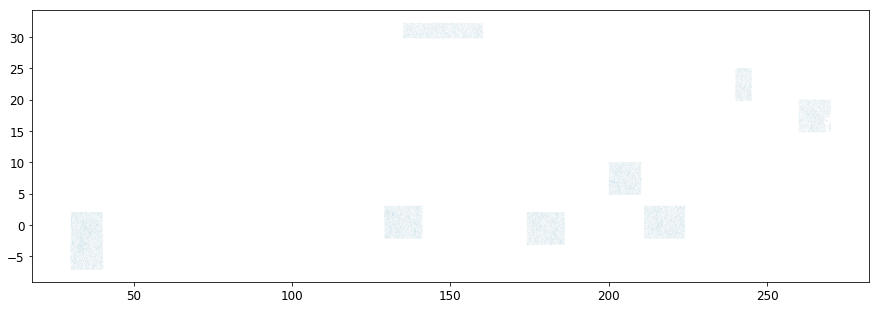

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'][::5], cat['DEC'][::5], '.', ms=0.1, alpha=0.1)
plt.show()

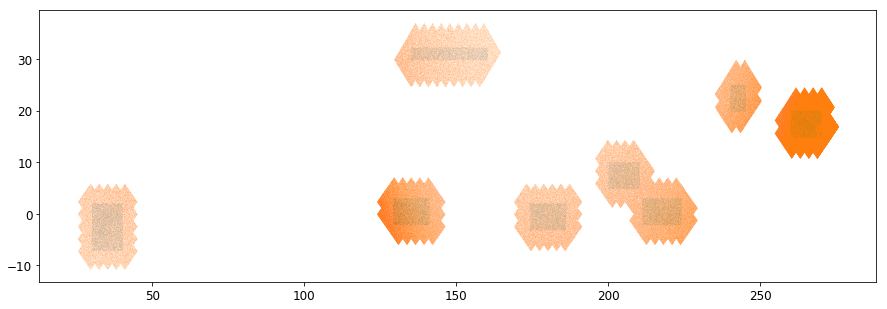

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'][::5], cat['DEC'][::5], '.', ms=0.1, alpha=0.1)
plt.plot(gaia['RA'][::5], gaia['DEC'][::5], '.', ms=0.1, alpha=0.1)
# plt.axis([0, 360, -23, 40])
plt.show()

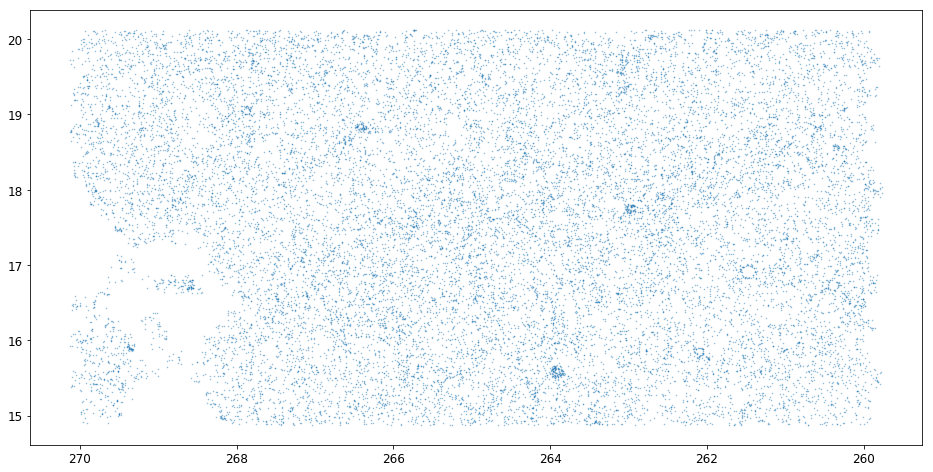

In [16]:
mask = cat['RA']>250
plt.figure(figsize=(16, 8))
plt.plot(cat['RA'][mask], cat['DEC'][mask], '.', ms=1, alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

In [17]:
mask = (gaia['PHOT_G_MEAN_MAG']>16) & (gaia['PHOT_G_MEAN_MAG']<17)
print(np.sum(mask), np.sum(mask)/len(mask))

ra1 = gaia['RA'][mask]
dec1 = gaia['DEC'][mask]
sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')

ra2 = cat['RA']
dec2 = cat['DEC']
sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')

754262 0.10180036325


20868 nearby objects


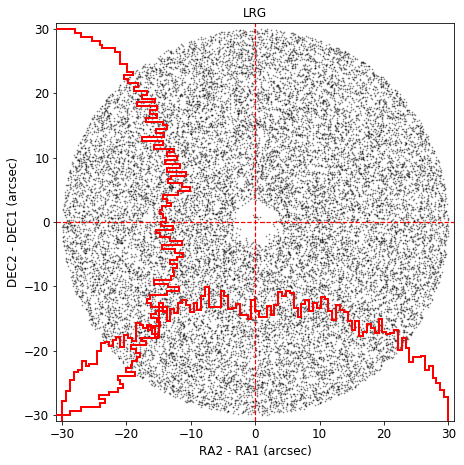

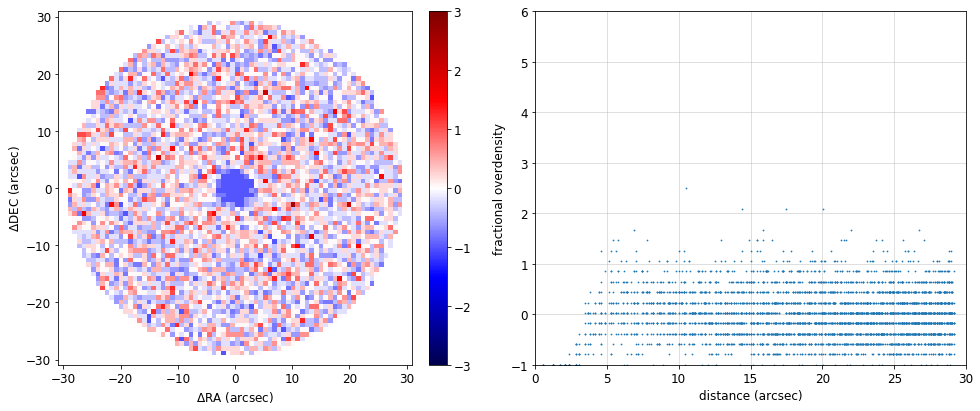

In [18]:
search_radius = 30.
# Paramater for estimating the overdensities
annulus_min = 25.
annulus_max = 30.

nbins = 75

idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
print('%d nearby objects'%len(idx1))

# convert distances to numpy array in arcsec
d2d = np.array(d2d.to(u.arcsec))

d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
# Convert d_ra to actual arcsecs
mask = d_ra > 180*3600
d_ra[mask] = d_ra[mask] - 360.*3600
mask = d_ra < -180*3600
d_ra[mask] = d_ra[mask] + 360.*3600
d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]
ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=target_class, show=False)
plt.show()

ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
_, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
plt.show()

__More plots!__

In [19]:
gaia_min_list = [-np.inf, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
gaia_max_list = [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
search_radius_list = [500, 350, 300, 250, 200, 150, 120, 90, 60, 30, 30, 30, 30, 30]

225 stars
1586 nearby objects


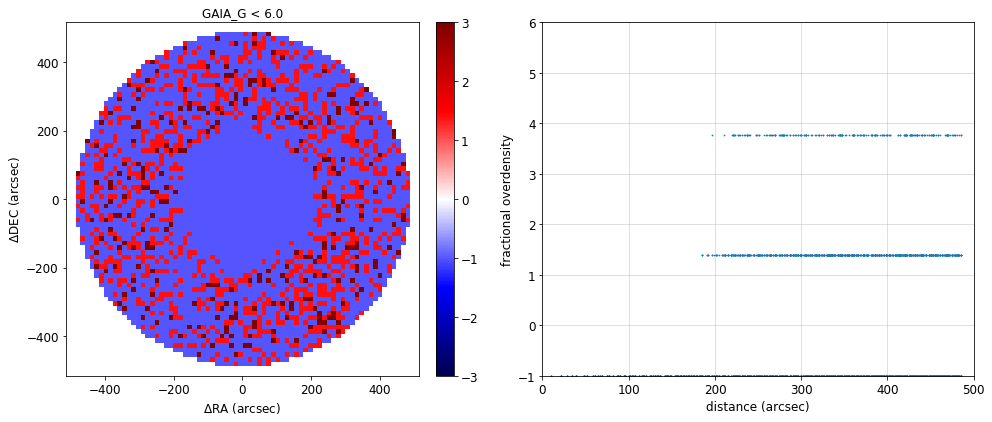

1666 stars
6101 nearby objects


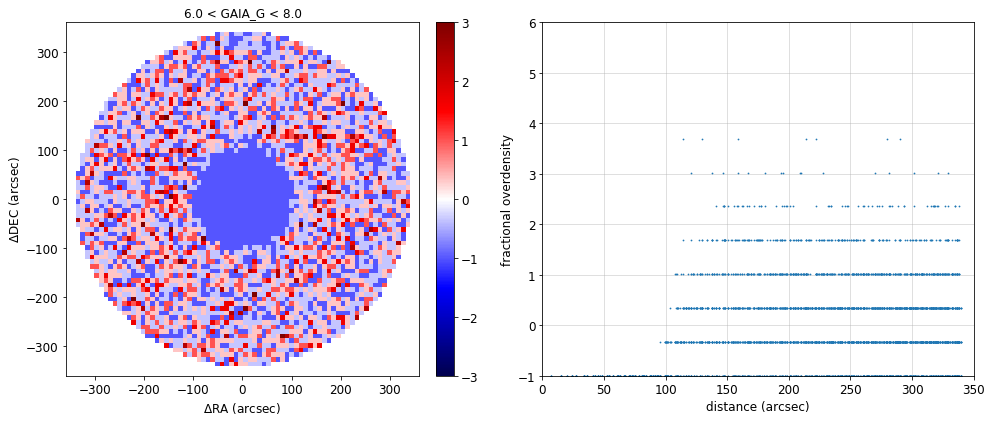

3026 stars
8148 nearby objects


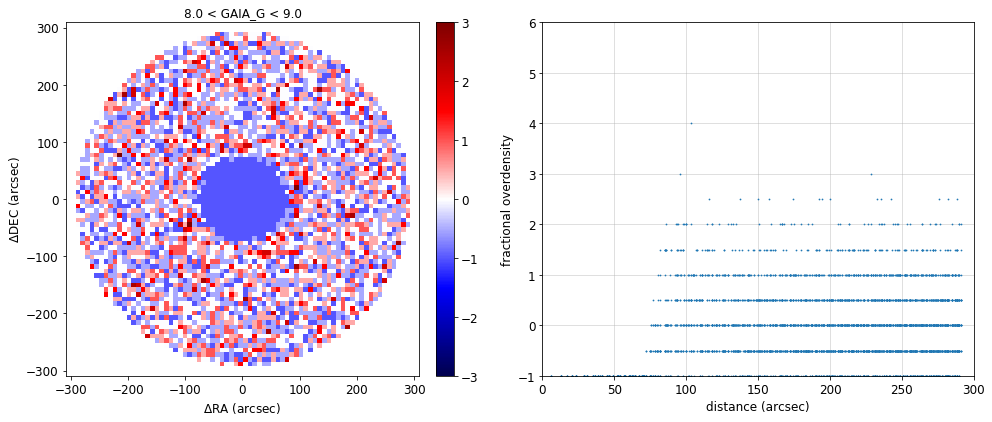

7251 stars
13988 nearby objects


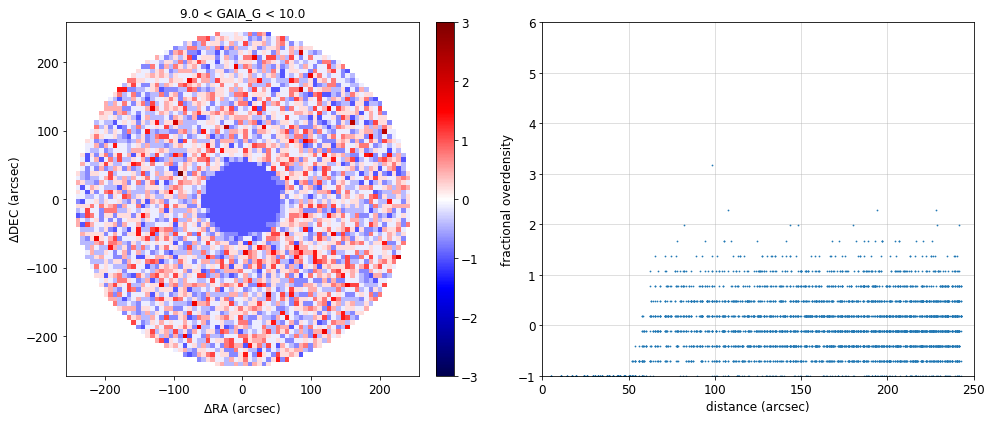

16437 stars
19873 nearby objects


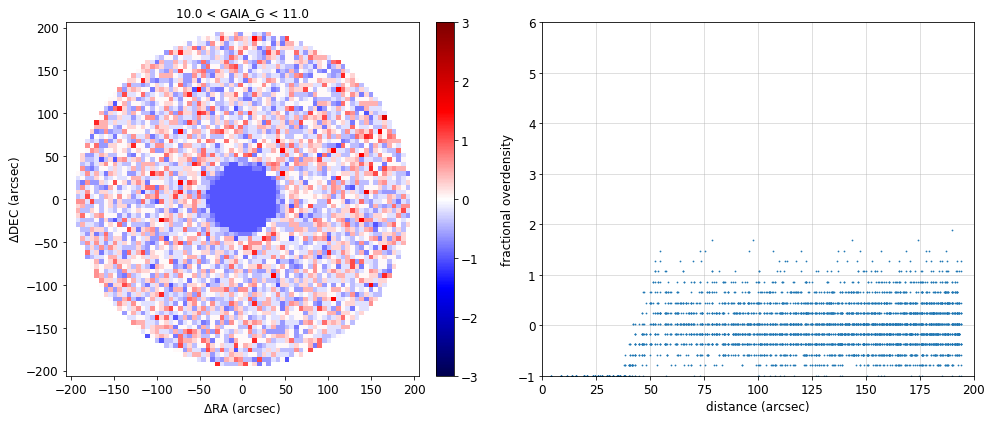

34776 stars
23508 nearby objects


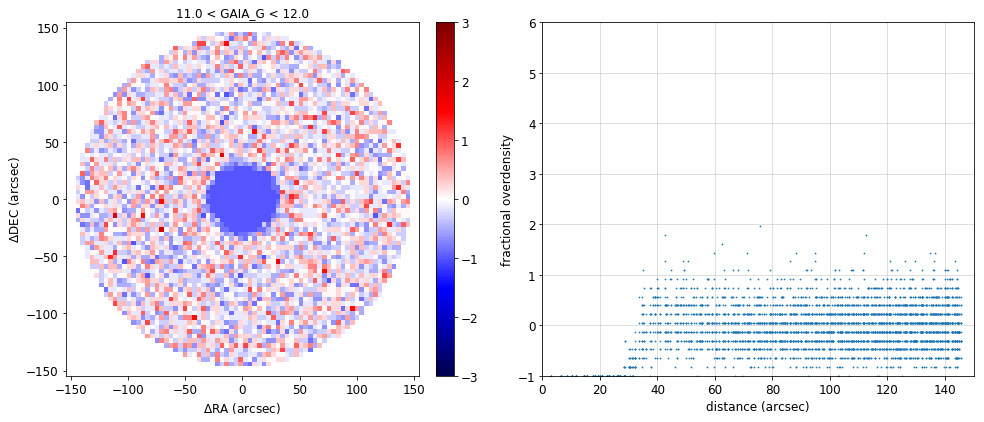

71322 stars
30815 nearby objects


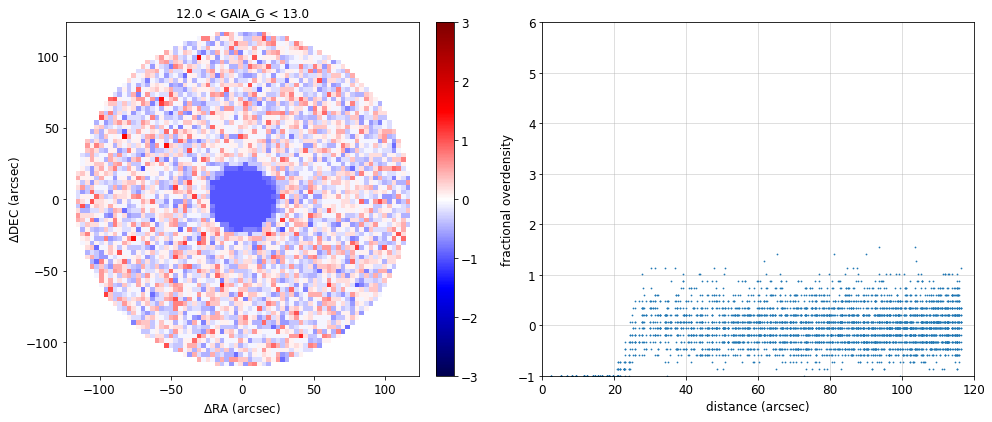

140909 stars
34295 nearby objects


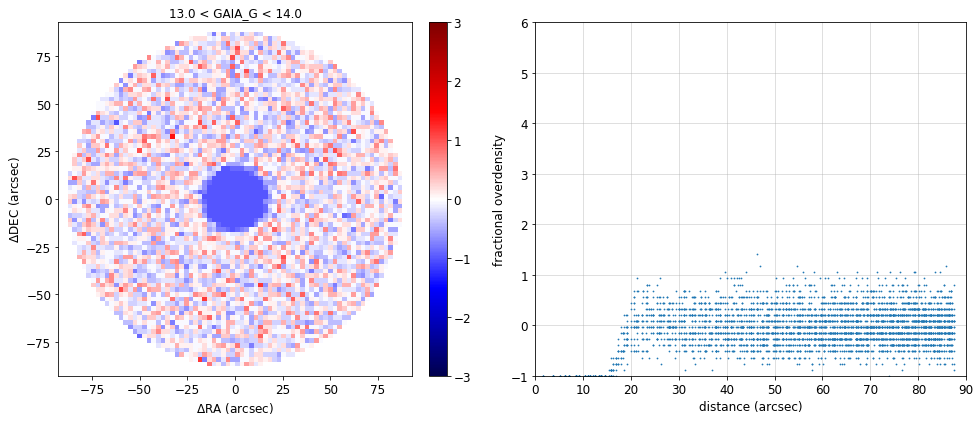

260670 stars
28175 nearby objects


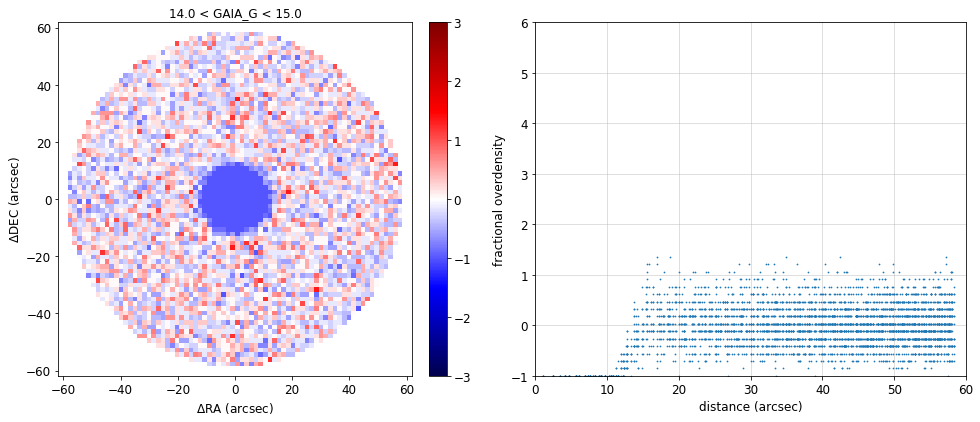

453566 stars
11603 nearby objects


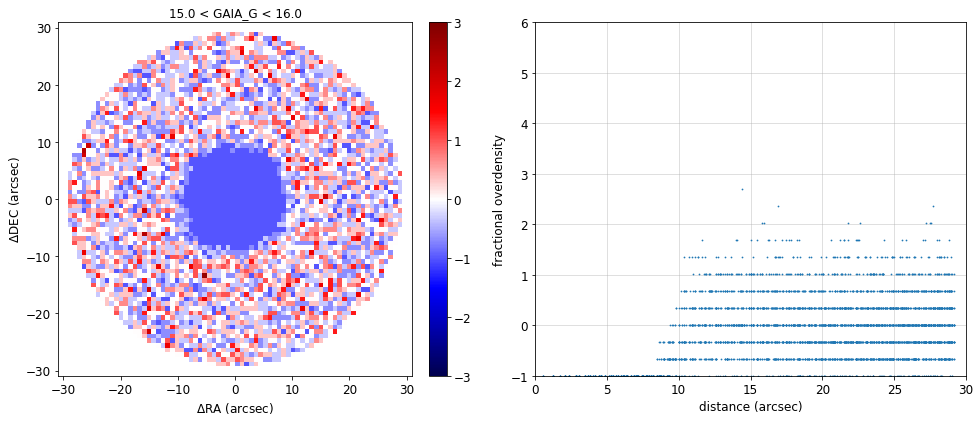

754262 stars
20868 nearby objects


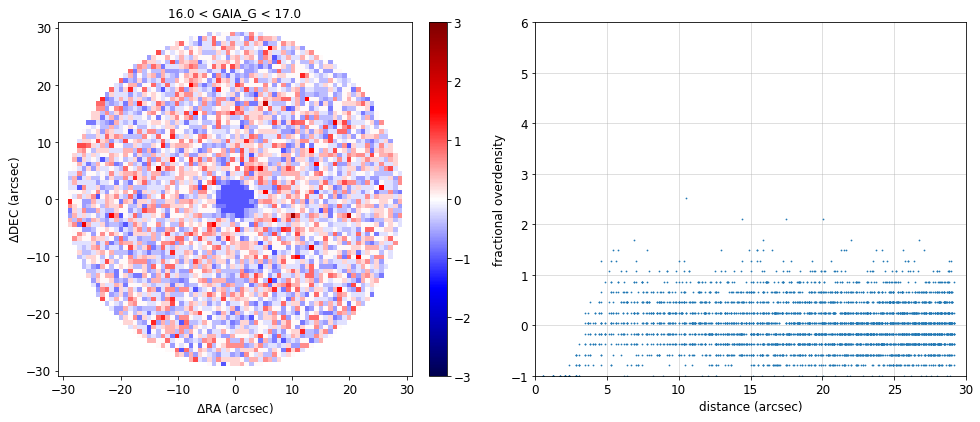

1197761 stars
32416 nearby objects


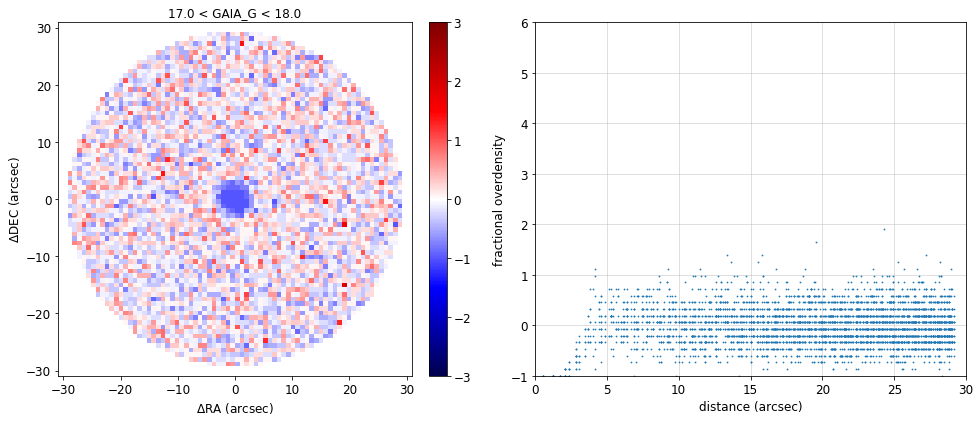

1810983 stars
47813 nearby objects


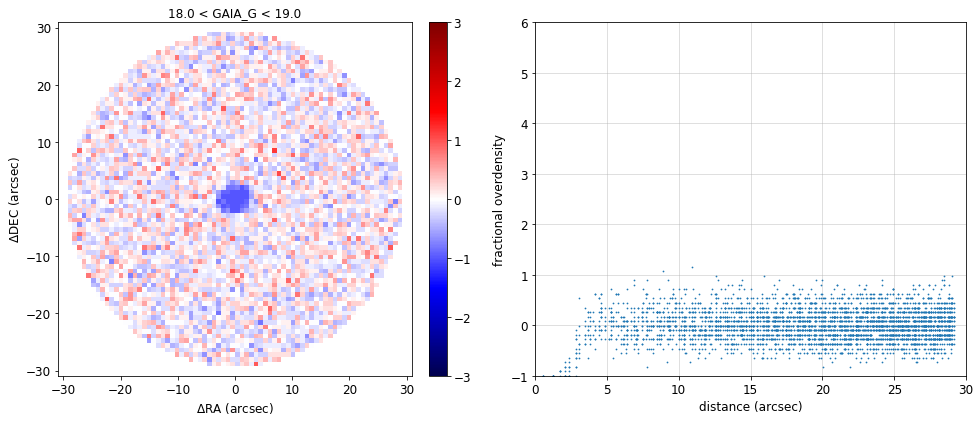

2656369 stars
69734 nearby objects


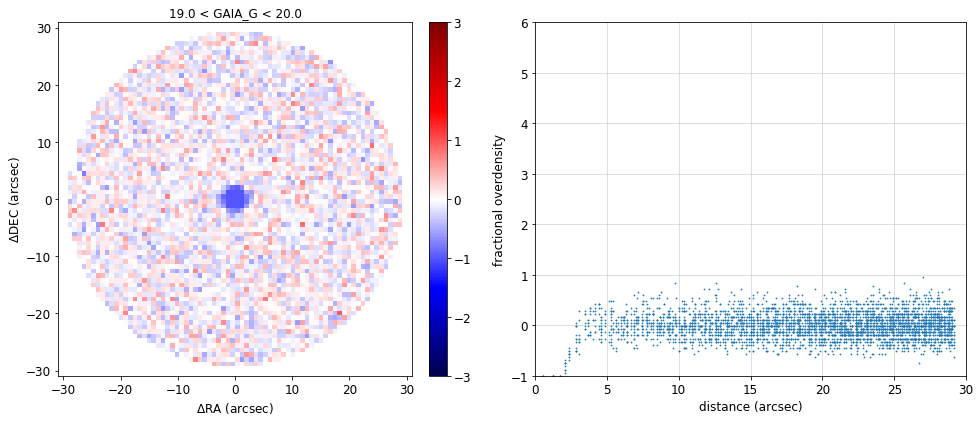

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('plots/LRG_DR8-SV_South.pdf') as pdf:

    for index in range(len(gaia_min_list)):

        nbins = 75
        search_radius = search_radius_list[index]
        axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]

        # Paramater for estimating the overdensities
        annulus_min, annulus_max = search_radius/3.*2, search_radius

        gaia_min, gaia_max = gaia_min_list[index], gaia_max_list[index]
        mask = (gaia['PHOT_G_MEAN_MAG']>gaia_min) & (gaia['PHOT_G_MEAN_MAG']<gaia_max)
        ra1 = gaia['RA'][mask]
        dec1 = gaia['DEC'][mask]
        if gaia_min==-np.inf:
            title = 'GAIA_G < {:.1f}'.format(gaia_max, np.sum(mask))
        else:
            title = '{:.1f} < GAIA_G < {:.1f}'.format(gaia_min, gaia_max, np.sum(mask))

        print('{} stars'.format(np.sum(mask)))

        sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
        idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
        print('%d nearby objects'%len(idx1))

        # convert distances to numpy array in arcsec
        d2d = np.array(d2d.to(u.arcsec))

        d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
        d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
        # Convert d_ra to actual arcsecs
        mask = d_ra > 180*3600
        d_ra[mask] = d_ra[mask] - 360.*3600
        mask = d_ra < -180*3600
        d_ra[mask] = d_ra[mask] + 360.*3600
        d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

        # markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
        # ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, show=False)
        # ax.set_title(title)
        # plt.show()

        ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
        density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
        ax, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
        ax[0].set_title(title)
        pdf.savefig()
        plt.show()

---------------
## North

In [21]:
target_path = '/global/cscratch1/sd/rongpu/dr9dev/dr8_targets_in_dr9sv_region/dr8_north.fits'
gaia_path = '/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_north.fits'
region = b'N'
target_class = 'LRG'
target_bit = target_bits[target_class]

In [22]:
gaia = fitsio.read(gaia_path, columns=gaia_columns)
print(len(gaia))

cat = fitsio.read(target_path, columns=['DESI_TARGET', 'PHOTSYS'])
print(len(cat))
mask = ((cat["DESI_TARGET"] & (2**target_bit))!=0) & (cat['PHOTSYS']==region)
idx = np.where(mask)[0]
cat = fitsio.read(target_path, columns=target_columns, rows=idx)
cat = Table(cat)
print(len(cat))

4259610
1547202
88327


In [23]:
# Apply mask bits
mask = np.ones(len(cat), dtype=bool)
for bit in [1, 5, 6, 7, 11, 12, 13]:
        mask &= ((cat['MASKBITS'] & 2**bit) == 0)
print('{:} ({:.1f}%) objects removed due to maskbits'.format(np.sum(~mask), np.sum(~mask)/len(mask)*100))
cat = cat[mask]

3393 (3.8%) objects removed due to maskbits


In [24]:
Table(gaia[:1])

RA,DEC,PHOT_G_MEAN_MAG
float64,float64,float32
146.043965084,28.6225823805,19.7795


In [25]:
cat[:1]

BRICKID,MORPHTYPE,RA,DEC,EBV,FLUX_G,FLUX_R,FLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,NOBS_G,NOBS_R,NOBS_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,WISEMASK_W1,WISEMASK_W2,MASKBITS,PHOTSYS,DESI_TARGET
int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,uint8,uint8,int16,bytes1,int64
601189,EXP,210.26879217,54.6978099579,0.00813513,0.18922,1.1097,7.12587,0.976206,0.983909,0.990967,3,4,4,20.1539,16.0502,0.998622,0.999154,0,0,0,N,33554705


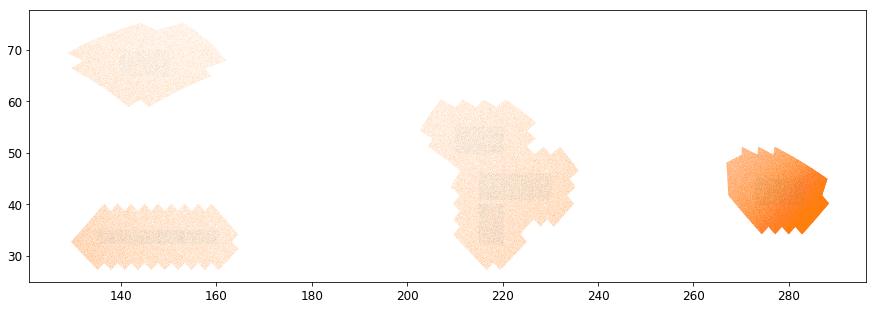

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'][::5], cat['DEC'][::5], '.', ms=0.1, alpha=0.1)
plt.plot(gaia['RA'][::5], gaia['DEC'][::5], '.', ms=0.1, alpha=0.1)
# plt.axis([0, 360, -23, 40])
plt.show()

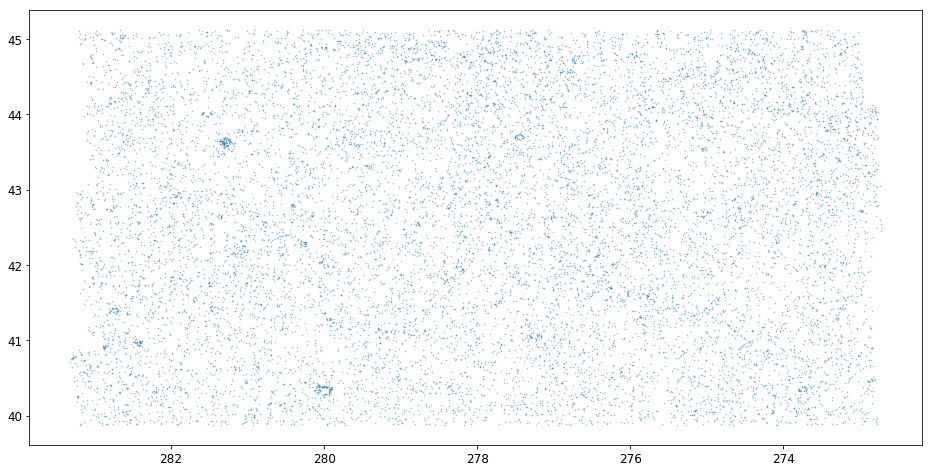

In [27]:
mask = cat['RA']>250
plt.figure(figsize=(16, 8))
plt.plot(cat['RA'][mask], cat['DEC'][mask], '.', ms=1, alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

In [28]:
mask = (gaia['PHOT_G_MEAN_MAG']>16) & (gaia['PHOT_G_MEAN_MAG']<17)
print(np.sum(mask), np.sum(mask)/len(mask))

ra1 = gaia['RA'][mask]
dec1 = gaia['DEC'][mask]
sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')

ra2 = cat['RA']
dec2 = cat['DEC']
sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')

463666 0.108851749339


7647 nearby objects


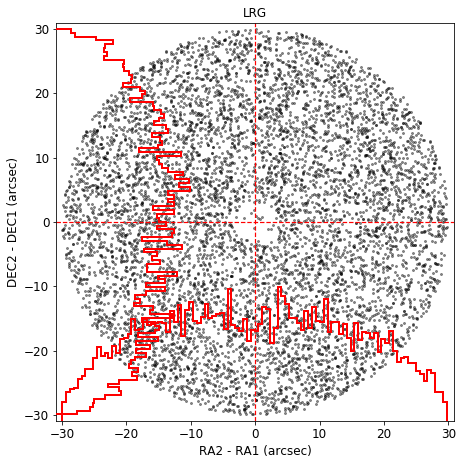

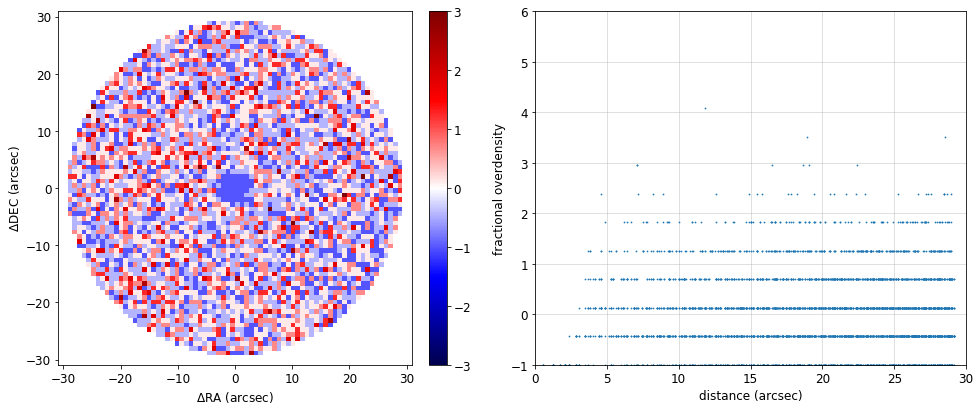

In [29]:
search_radius = 30.
# Paramater for estimating the overdensities
annulus_min = 25.
annulus_max = 30.

nbins = 75

idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
print('%d nearby objects'%len(idx1))

# convert distances to numpy array in arcsec
d2d = np.array(d2d.to(u.arcsec))

d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
# Convert d_ra to actual arcsecs
mask = d_ra > 180*3600
d_ra[mask] = d_ra[mask] - 360.*3600
mask = d_ra < -180*3600
d_ra[mask] = d_ra[mask] + 360.*3600
d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]
ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=target_class, show=False)
plt.show()

ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
ax, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
plt.show()

__More plots!__

In [30]:
gaia_min_list = [-np.inf, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
gaia_max_list = [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
search_radius_list = [500, 350, 300, 250, 200, 150, 120, 90, 60, 30, 30, 30, 30, 30]

147 stars
513 nearby objects


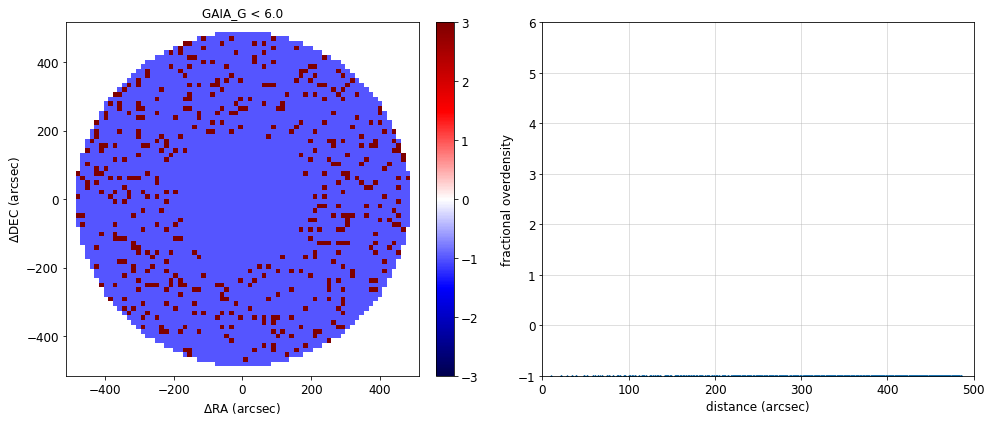

1092 stars
2362 nearby objects


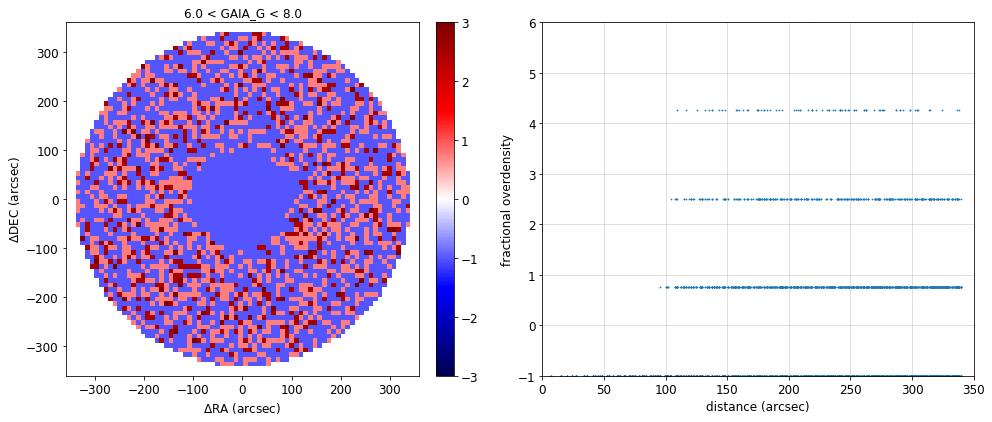

1927 stars
3474 nearby objects


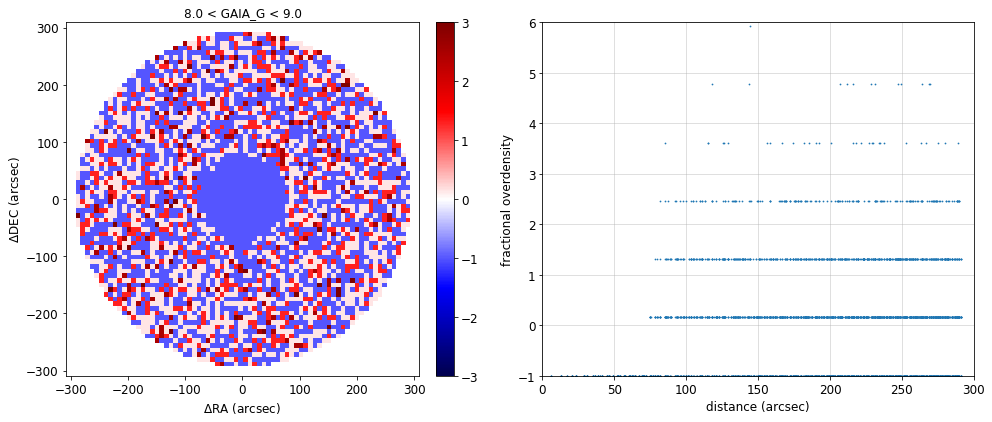

4698 stars
5218 nearby objects


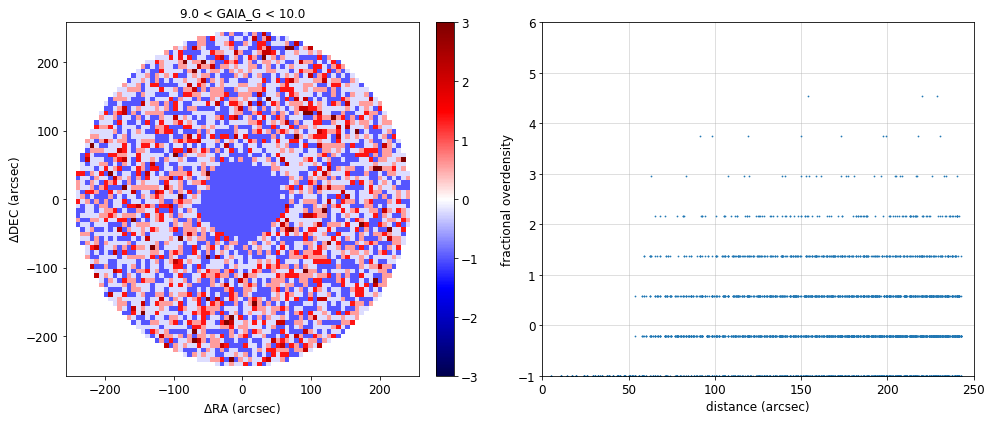

10530 stars
7483 nearby objects


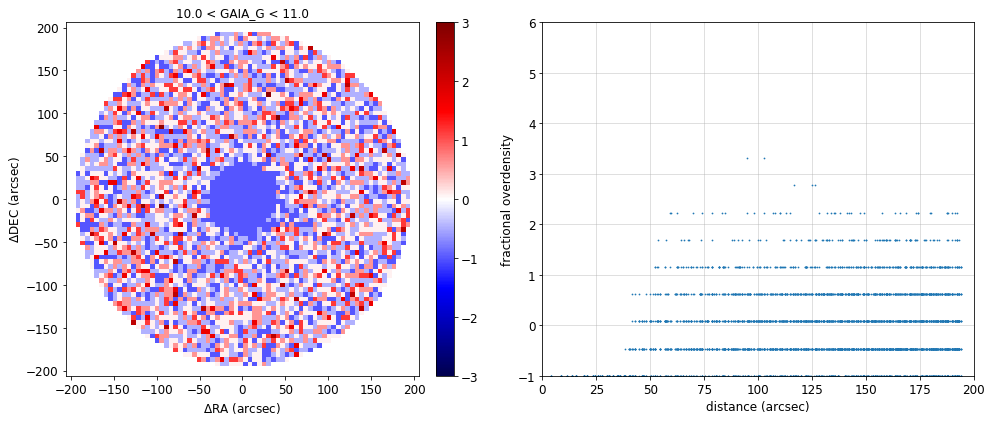

22003 stars
8835 nearby objects


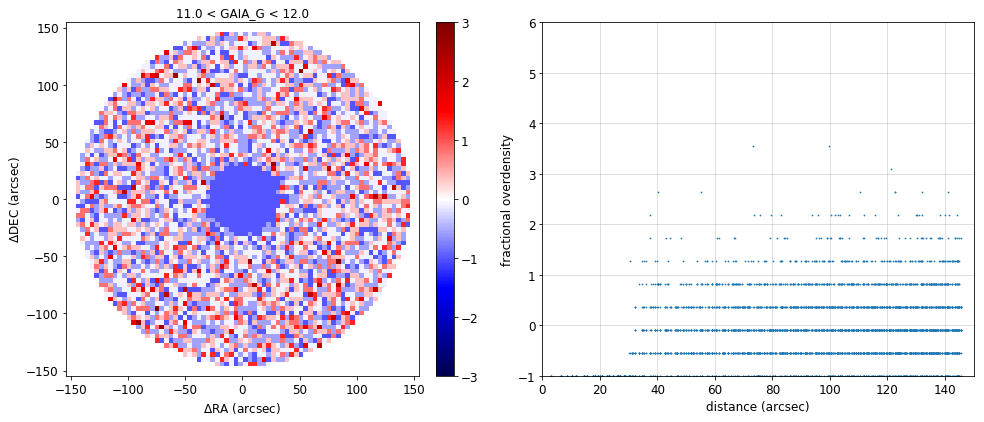

45260 stars
11289 nearby objects


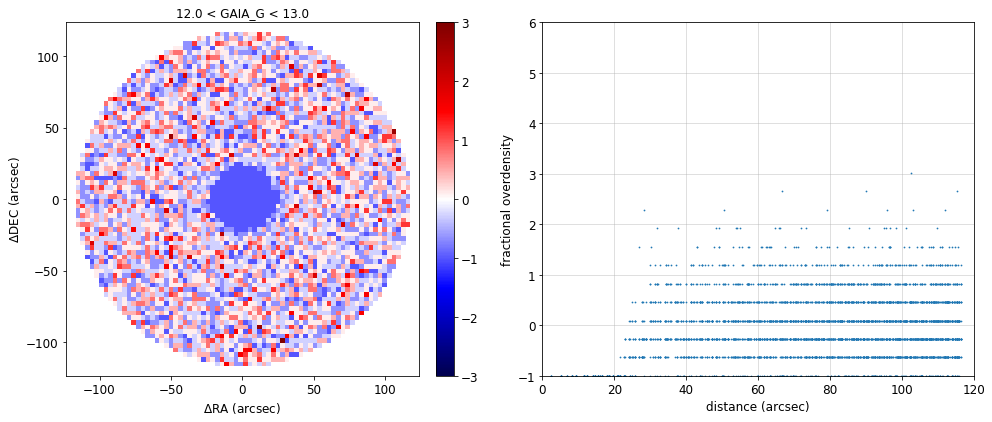

89207 stars
12406 nearby objects


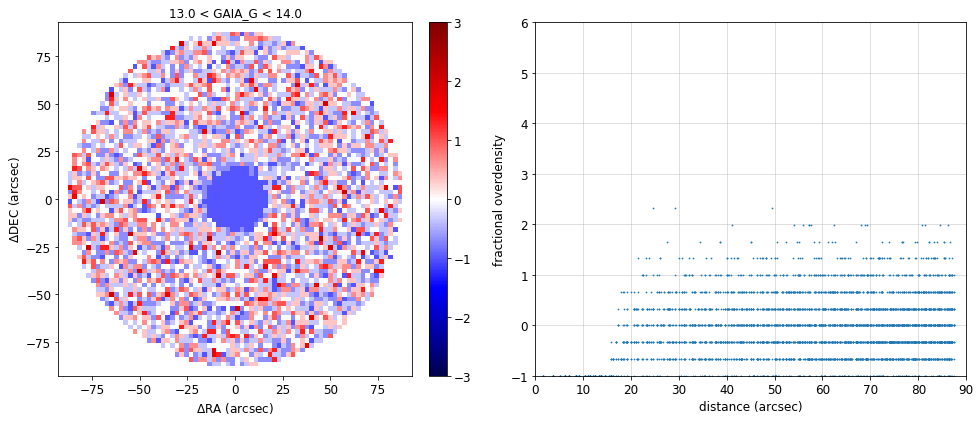

163365 stars
10294 nearby objects


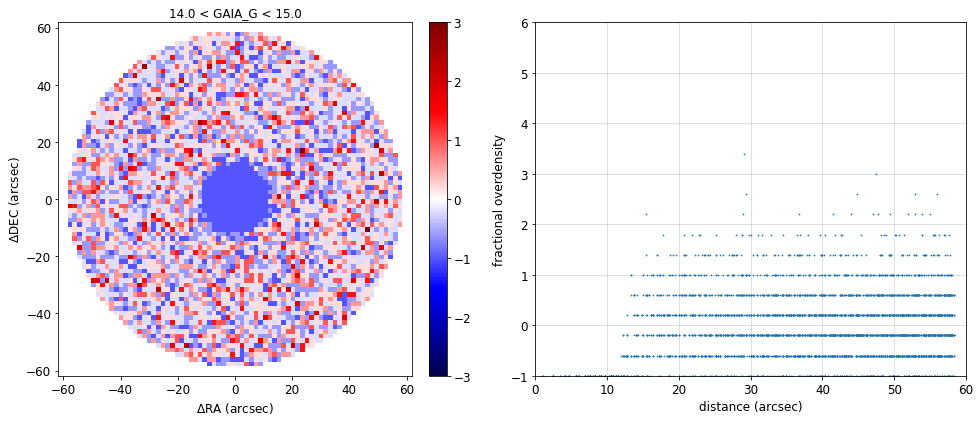

283999 stars
4227 nearby objects


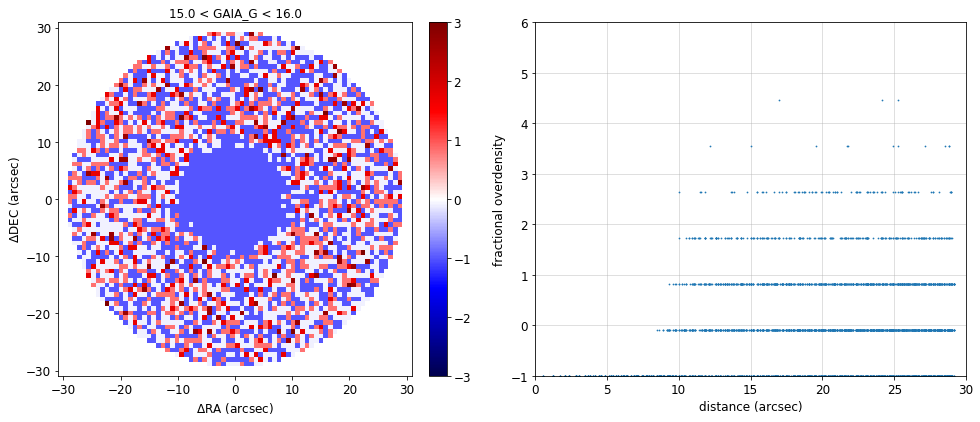

463666 stars
7647 nearby objects


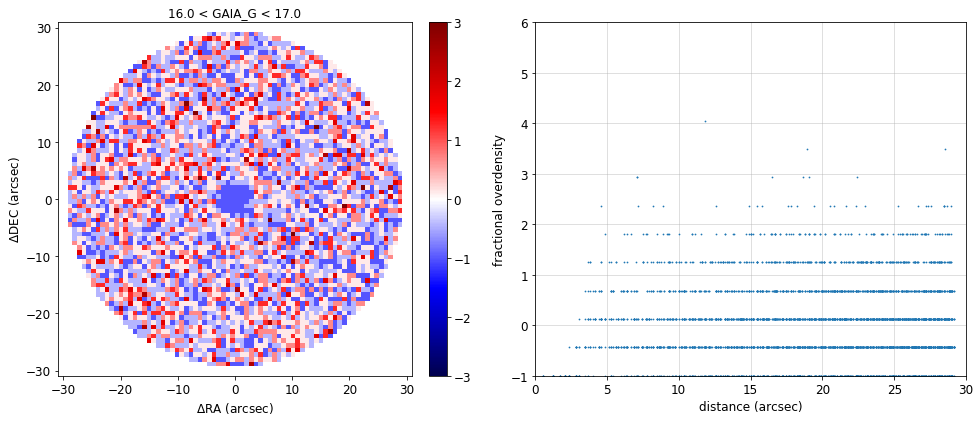

704458 stars
11369 nearby objects


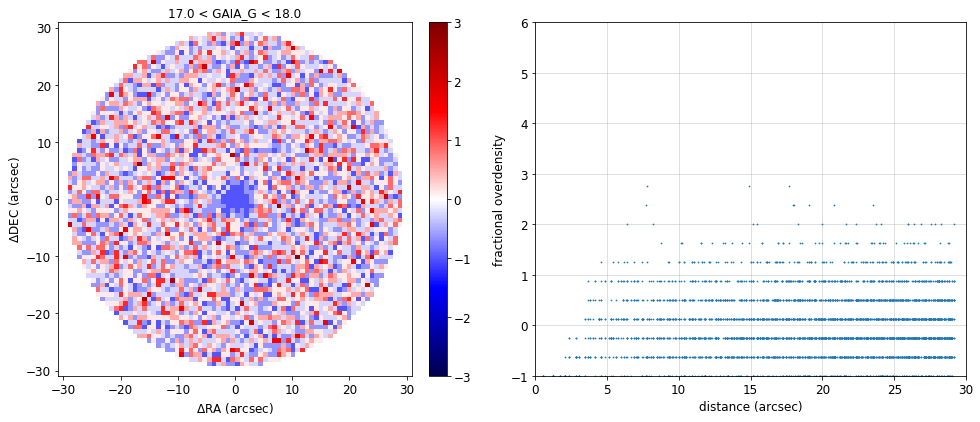

1016367 stars
16276 nearby objects


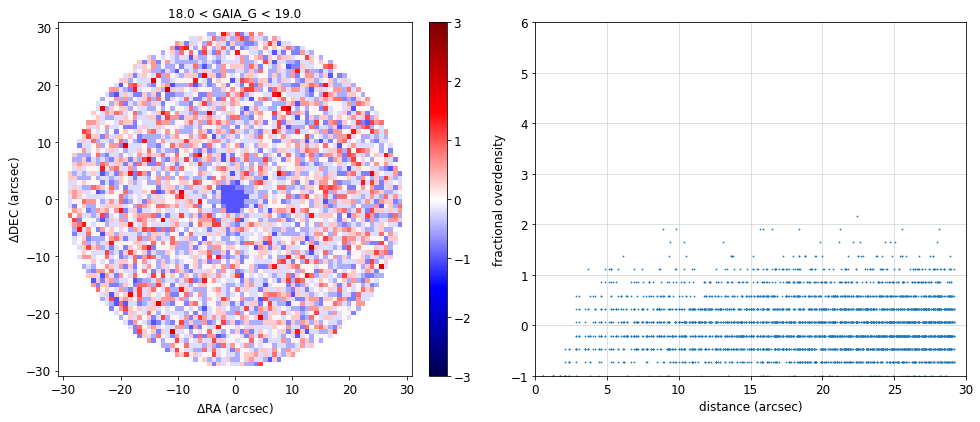

1452884 stars
23848 nearby objects


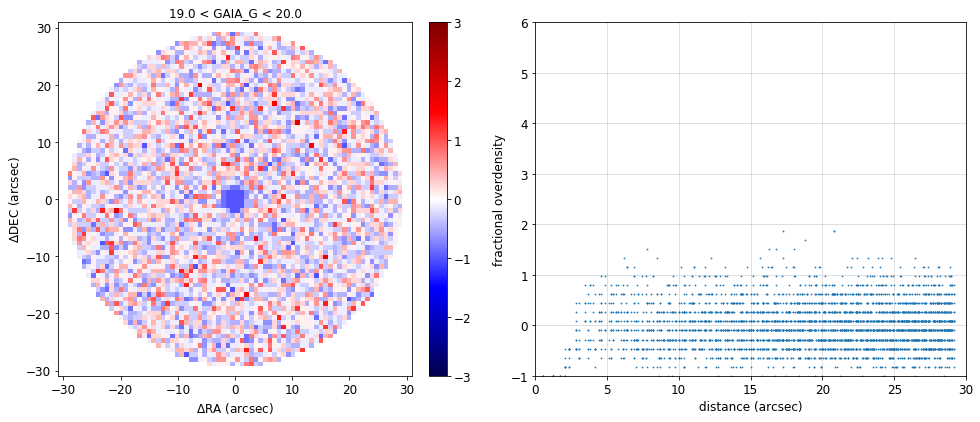

In [31]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('plots/LRG_DR8-SV_North.pdf') as pdf:

    for index in range(len(gaia_min_list)):

        nbins = 75
        search_radius = search_radius_list[index]
        axis = [-search_radius*1.03, search_radius*1.03, -search_radius*1.03, search_radius*1.03]

        # Paramater for estimating the overdensities
        annulus_min, annulus_max = search_radius/3.*2, search_radius

        gaia_min, gaia_max = gaia_min_list[index], gaia_max_list[index]
        mask = (gaia['PHOT_G_MEAN_MAG']>gaia_min) & (gaia['PHOT_G_MEAN_MAG']<gaia_max)
        ra1 = gaia['RA'][mask]
        dec1 = gaia['DEC'][mask]
        if gaia_min==-np.inf:
            title = 'GAIA_G < {:.1f}'.format(gaia_max, np.sum(mask))
        else:
            title = '{:.1f} < GAIA_G < {:.1f}'.format(gaia_min, gaia_max, np.sum(mask))

        print('{} stars'.format(np.sum(mask)))

        sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
        idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
        print('%d nearby objects'%len(idx1))

        # convert distances to numpy array in arcsec
        d2d = np.array(d2d.to(u.arcsec))

        d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
        d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
        # Convert d_ra to actual arcsecs
        mask = d_ra > 180*3600
        d_ra[mask] = d_ra[mask] - 360.*3600
        mask = d_ra < -180*3600
        d_ra[mask] = d_ra[mask] + 360.*3600
        d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)

        # markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
        # ax = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, show=False)
        # ax.set_title(title)
        # plt.show()

        ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
        density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
        ax, bins, mesh_d2d, density_ratio = relative_density_subplots(d_ra, d_dec, d2d, search_radius, ref_density=density_annulus, nbins=nbins)
        ax[0].set_title(title)
        pdf.savefig()
        plt.show()